#### Example of text classification with pre-trained FastText embeddings.

Reference pages:
- https://ai.intelligentonlinetools.com/ml/fasttext-word-embeddings-text-classification-python-mlp/
- Pre-trained FastText embeddings: https://fasttext.cc/docs/en/english-vectors.html

The finance complaints dataset was preprocessed in **finance complaints dataset analysis** notebook.

Loading balanced dataset.

In [1]:
import pandas as pd
df = pd.read_csv('complaints-balanced.csv')
df.head()

,Unnamed: 0,Product,Consumer_complaint_narrative,category_id
0,0,"Credit reporting, credit repair services, or o...",These aren't mine ... please remove it.,0
1,1,"Credit reporting, credit repair services, or o...",XXXX and Transunion are incorrectly reporting ...,0
2,2,"Credit reporting, credit repair services, or o...",I have been disputing a derogatory mark on my ...,0
3,3,"Credit reporting, credit repair services, or o...",I have sent 3 letters to all 3 credit bureau '...,0
4,4,"Credit reporting, credit repair services, or o...",ive been working back and forth calling emaili...,0


In [2]:
print(df.isnull().sum())

Unnamed: 0                      0
Product                         0
Consumer_complaint_narrative    0
category_id                     0
dtype: int64


Text preprocessing

In [8]:
%%time
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

text = df.Consumer_complaint_narrative
# removing numbers
text = text.apply(lambda x: re.sub(r'\d+', '', x))

# removing XXX words
text = text.apply(lambda x: re.sub(r'X*', '', x))

# tokenizing and removing punctuation
tokenizer = RegexpTokenizer(r'\w+')
text = text.apply(lambda x: tokenizer.tokenize(x))

# stop words removal
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words
text = text.apply(lambda x: remove_stopwords(x))

text.head()

CPU times: user 1min 36s, sys: 8.09 s, total: 1min 44s
Wall time: 1min 44s


0                        [These, mine, please, remove]
1    [Transunion, incorrectly, reporting, Authorize...
2    [I, disputing, derogatory, mark, credit, repor...
3    [I, sent, letters, credit, bureau, Equifax, ne...
4    [ive, working, back, forth, calling, emailing,...
Name: Consumer_complaint_narrative, dtype: object

Creating train and test sets, with balanced frequency of classes.

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3)
for train_index, test_index in sss.split(text, df['category_id']):
    train_set = text.loc[train_index]
    train_labels = df['category_id'].loc[train_index]
    test_set = text.loc[test_index]
    test_labels = df['category_id'].loc[test_index]

Loading word embeddings.

In [5]:
%%time
from gensim.models import KeyedVectors

word_model = KeyedVectors.load_word2vec_format('wiki-news-300d-1M.vec')

CPU times: user 6min 54s, sys: 3.72 s, total: 6min 58s
Wall time: 6min 58s


In [10]:
word_model.most_similar(positive='quality')

[('quantity', 0.722294807434082),
 ('Quality', 0.7010741233825684),
 ('high-quality', 0.6622669696807861),
 ('qualtiy', 0.6511572599411011),
 ('quality-', 0.6362133026123047),
 ('quaility', 0.6312156915664673),
 ('reliability', 0.6276414394378662),
 ('assurance', 0.6265413761138916),
 ('efficiency', 0.6185406446456909),
 ('quality.', 0.6173433661460876)]

Each document must be converted to a vector. So, we'll use the mean vector of its words.

In [17]:
import numpy as np

def word_averaging(doc, model):
    doc_vec =[]
    numw = 0
    for w in doc:
        try:
            if numw == 0:
                doc_vec = model[w]
            else:
                doc_vec = np.add(doc_vec, model[w])
            numw+=1
        except:
            pass
    
    return np.asarray(doc_vec) / numw

def word_averaging_list(model, text_list):
    return np.vstack([word_averaging(review, model) for review in text_list ])

In [18]:
%%time
X_train_word_average = word_averaging_list(word_model, train_set)
X_test_word_average = word_averaging_list(word_model, test_set)

CPU times: user 1.55 s, sys: 0 ns, total: 1.55 s
Wall time: 1.55 s


Let's train and evaluate some classifiers.

In [21]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.neural_network import MLPClassifier

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LogisticRegression(solver='lbfgs', max_iter=200, multi_class='auto', random_state=0),
    svm.LinearSVC(random_state=0),
    MLPClassifier(max_iter=1000, random_state=0)
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_train_word_average, train_labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

CPU times: user 3min 36s, sys: 2.18 s, total: 3min 38s
Wall time: 1min 56s


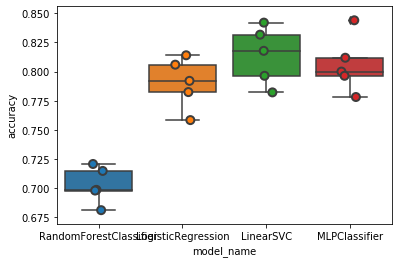

In [23]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [24]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.814018
LogisticRegression        0.790574
MLPClassifier             0.806101
RandomForestClassifier    0.702687
Name: accuracy, dtype: float64

Best model evaluation

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix

my_tags = df.category_id.unique()
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions, labels=my_tags)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

accuracy 0.8100092678405931
confusion matrix
 [[164  20  14  14   3]
 [ 37 155   4   8  12]
 [ 13  13 164   6  20]
 [  2   1   9 200   4]
 [  3   4  13   5 191]]
(row=expected, col=predicted)
CPU times: user 922 ms, sys: 3.95 ms, total: 926 ms
Wall time: 843 ms


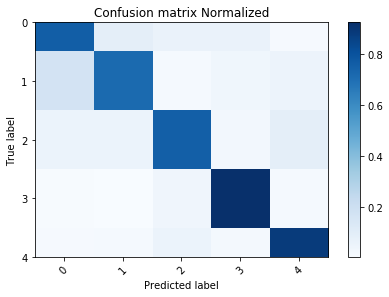

In [26]:
%%time
model = models[2]
model.fit(X_train_word_average, train_labels)
predicted = model.predict(X_test_word_average)
evaluate_prediction(predicted, test_labels)